In [1]:
import os 
import sys

import healpy as hp
import matplotlib.pyplot as plt
import numpy as np

import toast

import astropy.units as u 
import astropy as astro

In [2]:
from pixell import enmap, enplot, reproject, utils, curvedsky 
from scipy.optimize import curve_fit
from scipy.linalg import sqrtm

In [3]:
def eshow(x,**kwargs): 
    ''' Define a function to help us plot the maps neatly '''
    plots = enplot.get_plots(x, **kwargs)
    enplot.show(plots, method = "ipython")

In [4]:
env = toast.utils.Environment.get()
comm, procs, rank = toast.get_world()
nthread = os.environ["OMP_NUM_THREADS"]

In [5]:
mem = toast.utils.memreport(msg="(whole node)", comm=comm, silent=False)

Memory usage (whole node)
       total :  503.138 GB
   available :  200.754 GB
     percent :   60.100 % 
        used :  190.067 GB
        free :  117.037 GB
      active :   33.562 GB
    inactive :  271.653 GB
     buffers :   27.070 MB
      cached :  196.007 GB
      shared :   85.425 GB
        slab :   33.079 GB



In [6]:
def modulo_180(x):
    if x>180:
        return (x-360)
    else:
        return x

In [7]:
def modulo_360(x):
    if x<0:
        return (x+360)
    else:
        return x

In [8]:
modulo_180_vec = np.vectorize(modulo_180)
modulo_360_vec = np.vectorize(modulo_360)


0. Read Planck map

In [9]:
rGC = hp.rotator.Rotator(coord=['G','C'])  # Transforms galactic to equatorial coordinates
rCG = hp.rotator.Rotator(coord=['C','G'])  # Transforms equatorial to galactic coordinates


In [10]:
NSIDE = 512
lmax = 2*NSIDE

In [11]:
npix = hp.nside2npix(nside=NSIDE)

In [12]:
resol = hp.nside2resol(nside=NSIDE)
amin2rad = np.pi/(60*180)

resol_amin = resol*amin2rad

print(resol)

0.0019986849764579854


In [13]:
keys = {"downgrade": 8, "ticks": 10, "colorbar": True}  

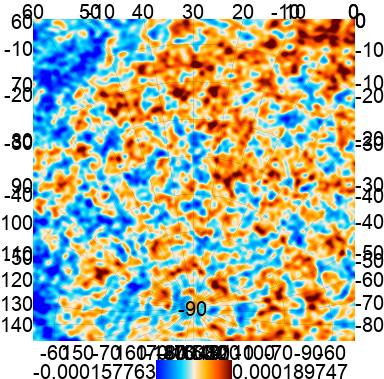

In [14]:
planck_map_car = enmap.read_map('cmb_030_GC_nside_I_car.FITS')
# Visualize using eshow
eshow(planck_map_car, **keys)

In [15]:
shape = planck_map_car.shape
wcs = planck_map_car.wcs

Create a telescope and corresponding pointing

1. Start by creating a focalplane with a sample rate and number of detectors

In [16]:
from toast.qarray import to_iso_angles, rotation, mult, to_lonlat_angles


In [17]:
from toast.instrument_sim import fake_hexagon_focalplane, plot_focalplane

In [18]:
xrot = rotation(np.array([0.,1.,0.]),np.pi/2)

In [19]:
focalplane = toast.instrument.Focalplane(sample_rate=10*u.Hz#,thinfp=256
                                        )
##One fourth of total detectors in the focalplane
## For S4, sample rate ~10-100

with toast.io.H5File("focalplane_SAT3_SAT_f030.h5", "r", comm=comm, force_serial=True) as f:
            focalplane.load_hdf5(f.handle, comm=comm)

In [20]:
iso_angles = np.array([np.degrees(to_iso_angles(mult(xrot,focalplane[detec]["quat"]))) for detec in focalplane.detectors])


In [21]:
focalplane._det_to_row = {'029_000_SAT_f030_A': 0,
  '029_003_SAT_f030_A': 6}

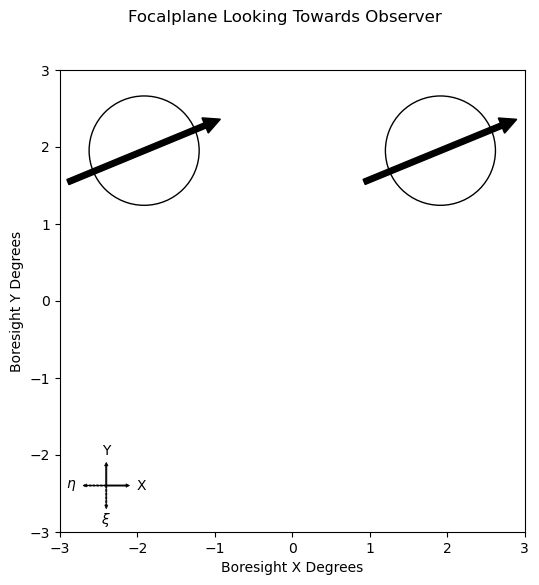

<Figure size 640x480 with 0 Axes>

In [22]:
plot_focalplane(focalplane, width=5*u.degree, height = 5*u.degree)
plt.savefig('two_detectors.png')

Print schedule information

In [23]:
schedule = toast.schedule.GroundSchedule()
schedule.read("POLE_DEEP_169-DEC0.txt", comm=comm)

TOAST INFO: Loading schedule from POLE_DEEP_169-DEC0.txt
TOAST INFO: Loaded 1 scans from POLE_DEEP_169-DEC0.txt totaling 84.0 minutes.


In [24]:
schedule

<GroundSchedule site=SOUTH_POLE at -90.0 deg, -44.65 deg, 2843.0 m telescope SAT with 1 scans
  <GroundScan 'POLE_DEEP' at 2000-01-01T12:00:00+00:00 with El = 54.52 deg, Az 118.39 deg -- 189.2 deg>
>

Print telescope information

In [25]:
site = toast.instrument.GroundSite(
        schedule.site_name,
        schedule.site_lat,
        schedule.site_lon,
        schedule.site_alt,
        weather=None,
    )
telescope = toast.instrument.Telescope(
        "My_telescope", focalplane=focalplane, site=site
    )

telescope

<Telescope 'My_telescope': uid = 3533178314, site = <GroundSite 'SOUTH_POLE' : uid = 588178429, lon = -44.64999999999998 deg, lat = -90.0 deg, alt = 2843.0 m, weather = None>, focalplane = <Focalplane: 252 detectors, sample_rate = 10.0 Hz, FOV = 29.77320077597548 deg, detectors = [029_000_SAT_f030_A .. 029_003_SAT_f030_A]>>

We can have multiple groups for parallel computing (start with one). Create a Data Instance and simulate a ground observation operator.

In [26]:
toast_comm = toast.Comm(world=comm, groupsize=1)

In [27]:
data = toast.Data(comm=toast_comm)

In [28]:
sim_ground = toast.ops.SimGround(name="sim_ground", 
                                 weather="south_pole", 
                                 detset_key="pixel", 
                                 telescope = telescope, 
                                 schedule = schedule
                                ) ##simulate motion of the boresight

In [29]:
sim_ground.apply(data)

1. Create a focalplane with only two detectors in the same row with the same polarization
2. Two timestreams and see where scans overlap (?)
3. Fit a step function and substract it. How to adjust level at the end of overlap?
4. bin 

In [78]:
pointing = toast.ops.PointingDetectorSimple(coord_in='C',coord_out='C') ##boresight pointing into detector frame (RA/DEC by default)
pointing.apply(data)

2. Noise simulation

In [79]:
ob = data.obs[0]

In [80]:
time = ob.shared['times']

In [81]:
ntime = time.shape

In [82]:
clon,clat = wcs.wcs.crval*u.degree

In [83]:
wcs

car:{cdelt:[0.03333,0.03333],crval:[30,-56],crpix:[1290.00,1290.00]}

In [84]:
pixels_wcs = toast.ops.pixels_wcs.PixelsWCS(detector_pointing = pointing,center =(clon,clat),dimensions=shape,resolution=(.03333*u.degree,.03333*u.degree))
pixels_wcs.pixels = 'pixels_wcs'

In [112]:
pixels_wcs.create_dist = 'PixelsWCSDistribution'

In [113]:
pixels_wcs

<PixelsWCS
  API = 0 # Internal interface version for this operator
  auto_bounds = False # If True, set the bounding box based on boresight and field of view
  bounds = () # The (lon_min, lon_max, lat_min, lat_max) values (Quantities)
  center = (<Quantity 30. deg>, <Quantity -56. deg>) # The center Lon/Lat coordinates (Quantities) of the projection
  center_offset = None # Optional name of shared field with lon, lat offset in degrees
  create_dist = PixelsWCSDistribution # Create the submap distribution for all detectors and store in the Data key specified
  detector_pointing = <PointingDetectorSimple
  API = 0 # Internal interface version for this operator
  boresight = boresight_radec # Observation shared key for boresight
  coord_in = C # The input boresight coordinate system ('C', 'E', 'G')
  coord_out = C # The output coordinate system ('C', 'E', 'G')
  det_mask = 1 # Bit mask value for per-detector flagging
  enabled = True # If True, this class instance is marked as enabled
  

# Pixel pointing

By default, pixels are in NESTED ordering instead of RING!!!

In [114]:
pixels_wcs.apply(data)

In [115]:
pixels_wcs.pixels

'pixels_wcs'

In [120]:
data['PixelsWCSDistribution']

<PixelDistribution 6656400 pixels, 10 submaps, submap size = 665640>

In [121]:
2580*2580

6656400

In [89]:
pix_wcsarr = ob.detdata['pixels_wcs']

### Hitmap

In [90]:
quats1 = ob.detdata['quats'][0]

In [91]:
iso_dec1 = np.degrees(to_lonlat_angles(quats1))

In [92]:
iso_dec1

array([[ -2.3359727 ,  -2.16326955,  -1.99056641, ...,  79.03898647,
         78.86712169,  78.69525672],
       [-56.42096274, -56.42095812, -56.42095351, ..., -56.42039813,
        -56.42039581, -56.4203935 ],
       [-64.61601954, -64.6160245 , -64.61602948, ..., -64.62019492,
        -64.62018695, -64.62017896]])

In [93]:
ra_arr,dec_arr = iso_dec1[0:2]

In [94]:
coords_arr   = np.deg2rad(np.array([dec_arr,ra_arr]))

In [95]:
coords_arr

array([[-0.98473157, -0.98473149, -0.98473141, ..., -0.98472171,
        -0.98472167, -0.98472163],
       [-0.04077041, -0.03775618, -0.03474194, ...,  1.37949055,
         1.37649095,  1.37349134]])

In [96]:
ypix,xpix = np.rint(enmap.sky2pix(shape,wcs,coords_arr))

In [97]:
ypix,xpix

(array([1154., 1155., 1157., ..., 1004., 1005., 1007.]),
 array([ 771.,  774.,  776., ..., 2041., 2039., 2036.]))

In [98]:
hitmap1 = enmap.zeros(planck_map_car.shape,planck_map_car.wcs)

In [99]:
hitmap1.shape

(2580, 2580)

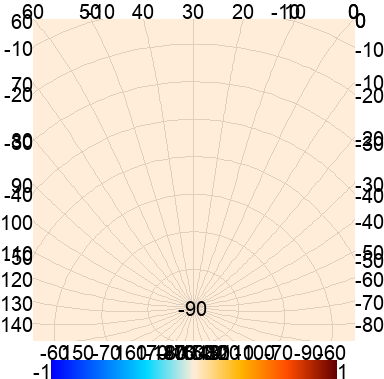

In [100]:
eshow(hitmap1,**keys)

In [101]:
for i in range(ntime[0]):
    hitmap1[int(ypix[i]),int(xpix[i])]=100

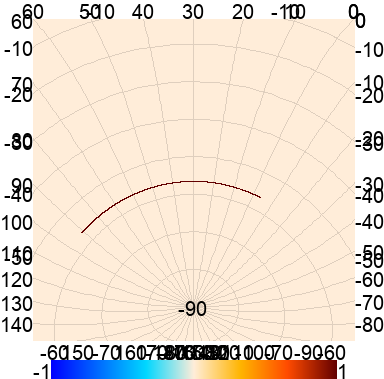

In [102]:
eshow(hitmap1,**keys)

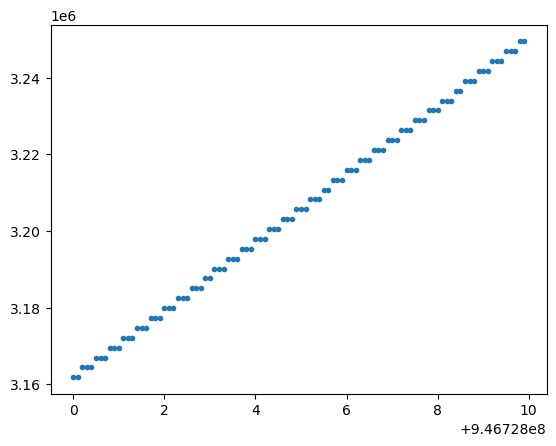

In [128]:
plt.plot(time[:100],pix_wcsarr[0][:100],'.')

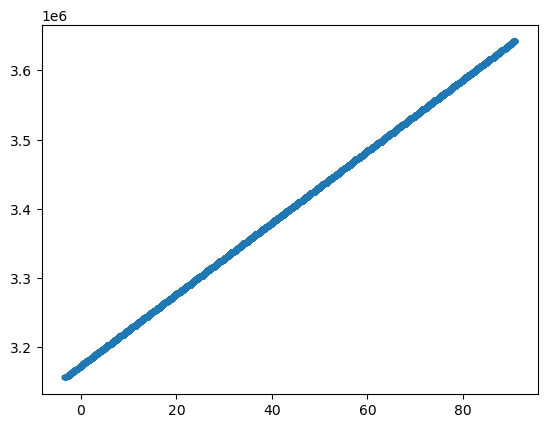

In [123]:
plt.plot(ra_arr,pix_wcsarr[0],'.')

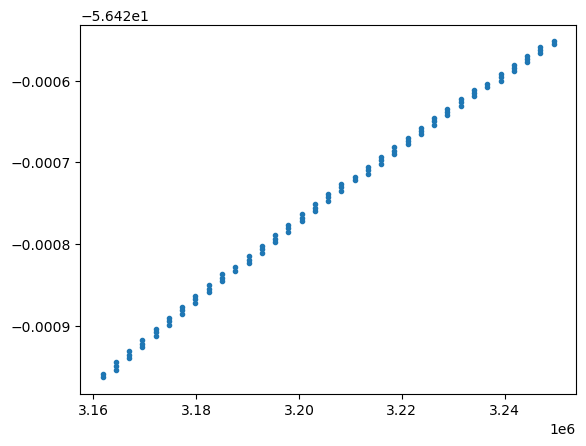

In [127]:
plt.plot(pix_wcsarr[0][0:100],dec_arr[0:100],'.')

In [122]:
pix_wcsarr

<DetectorData 2 detectors each with shape (50400,), type int64, units :
  029_000_SAT_f030_A = [ 3161789 3161789 ... 3579749 3579749 ]
  029_003_SAT_f030_A = [ 3125669 3125669 ... 3543629 3543629 ]
>

In [56]:
shape

(2580, 2580)

In [71]:
x_arr

array([1225, 1225, 1226, ..., 1388, 1387, 1387])

In [72]:
pix_wcsarr[0]%2580

array([1289, 1289, 1289, ..., 1289, 1289, 1289])

In [69]:
3249509-3246929

2580

In [59]:
def pix2coords(pix,shape):
    lat,lon = shape
    return(pix//lat,pix%lat)

In [60]:
x_arr,y_arr = pix2coords(pix = pix_wcsarr[0],shape = shape)

In [61]:
x_arr

array([1225, 1225, 1226, ..., 1388, 1387, 1387])

In [62]:
hitmap = enmap.zeros(planck_map_car.shape,planck_map_car.wcs)

In [63]:
hitmap.shape

(2580, 2580)

In [64]:
(5755-5197)/10800

0.051666666666666666

In [65]:
for i in range(0,ntime[0]):
    hitmap[y_arr[i],x_arr[i]]+=1

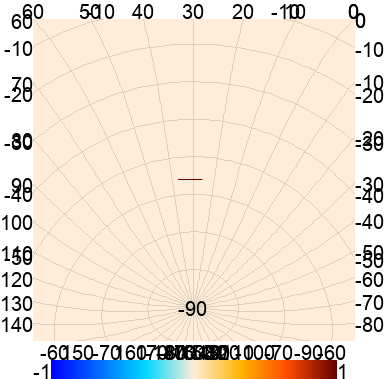

In [66]:
eshow(hitmap,**keys)